<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session6/Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [42]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(                      
            
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 26, RF = 3
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 24, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout2d(0.02),

        nn.MaxPool2d(kernel_size=(2,2)), #Op_size = 12, RF = 6

        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 10, RF = 10   
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 8, RF = 14
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout2d(0.02),

        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),#Op_size = 6, RF = 18 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.02),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 6, RF = 22 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.02),

        nn.AvgPool2d(kernel_size=6),



        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, RF = 28
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [44]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
        Dropout2d-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)

  
  return factor * reg_loss

In [0]:
from tqdm import tqdm




def train(model, device, train_loader, optimizer, epoch, isL1=False):
  isL1 = True
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
   #CAlculate L1 loss
    if(isL1==True):
      loss += L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    

def test(model, device, test_loader, test_losses, test_acc, misclassified):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i]!= target[i]:
                misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

# Let's Train and test our model

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_test_loss_acc(test_losses,test_acc):
  fig, axs = plt.subplots(1,2,figsize=(15,10))
  axs[0].plot(test_losses)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc)
  axs[1].set_title("Test Accuracy")

# **Plot Misclassified Images** 

In [0]:

def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
        
  plt.tight_layout()

  plt.show()

In [0]:

def without_L1L2():
  
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_without_L1L2_Loss, test_without_L1L2_acc,misclassifiedwithoutL1L2)

  plot_test_loss_acc(test_without_L1L2_Loss,test_without_L1L2_acc)
  plot_misclassified(misclassifiedwithoutL1L2)

In [0]:
def with_L1():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1_Loss, test_with_L1_acc,misclassifiedL1)

  plot_test_loss_acc(test_with_L1_Loss, test_with_L1_acc)
  plot_misclassified(misclassifiedL1)


In [0]:
def with_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False)
      test(model, device, test_loader,test_with_L2_Loss, test_with_L2_acc,misclassifiedL2)

  plot_test_loss_acc(test_with_L2_Loss,test_with_L2_acc)
  plot_misclassified(misclassifiedL2)

In [0]:
def with_L1_L2():
    
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

  #scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True)
      test(model, device, test_loader,test_with_L1L2_Loss, test_with_L1L2_acc,misclassifiedL1L2)

  plot_test_loss_acc(test_with_L1L2_Loss,test_with_L1L2_acc)
  plot_misclassified(misclassifiedL1L2)

In [0]:
test_without_L1L2_Loss = []
test_without_L1L2_acc = []
misclassifiedwithoutL1L2= []

test_with_L1_Loss = []
test_with_L1_acc = []
misclassifiedL1 = []

test_with_L2_Loss = []
test_with_L2_acc = []
misclassifiedL2 = []

test_with_L1L2_Loss = []
test_with_L1L2_acc = []
misclassifiedL1L2 = []

from torch.optim.lr_scheduler import StepLR

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1162726953625679 Batch_id=468 Accuracy=87.50: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9808/10000 (98.08%)

EPOCH: 1


Loss=0.05825923755764961 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.04525322467088699 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.03574158996343613 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.05119339004158974 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.07462215423583984 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.026538945734500885 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.0417708121240139 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.06748122721910477 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.019838398322463036 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.031349994242191315 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.03719308227300644 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.08882525563240051 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.01108093373477459 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.04624619707465172 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.026489071547985077 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.013851952739059925 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.09795127809047699 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.01898561231791973 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.020074225962162018 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.009685062803328037 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.04731636494398117 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.05932612717151642 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.007070949301123619 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.027760099619627 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.019505903124809265 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.014797383919358253 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9932/10000 (99.32%)

EPOCH: 27


Loss=0.058812450617551804 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

EPOCH: 28


Loss=0.007789447903633118 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 29


Loss=0.03794025257229805 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Loss=0.015245744958519936 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

EPOCH: 31


Loss=0.009764300659298897 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 32


Loss=0.010258073918521404 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.009862341918051243 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.020878102630376816 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 35


Loss=0.007312930189073086 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 36


Loss=0.01386314444243908 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.022716576233506203 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 38


Loss=0.08634018898010254 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.028748776763677597 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 41.86it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)



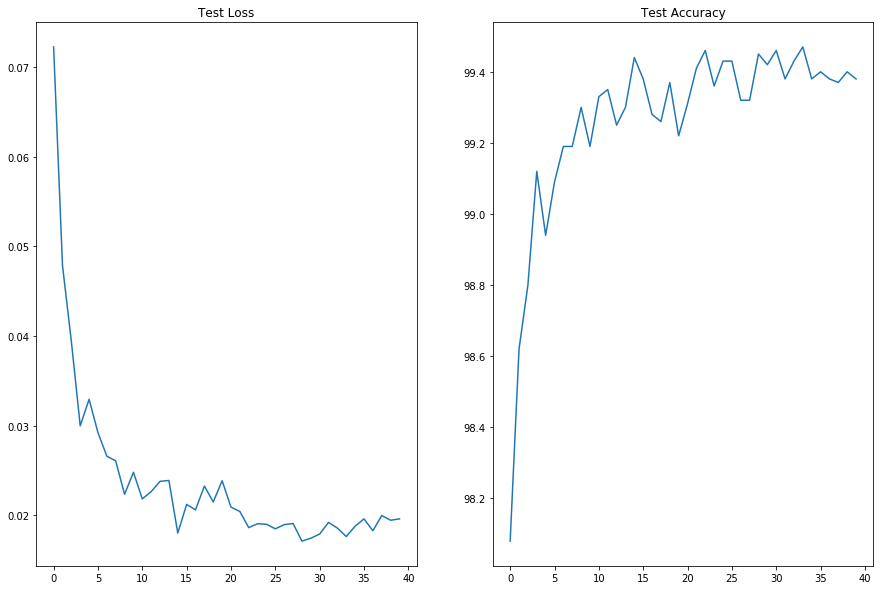

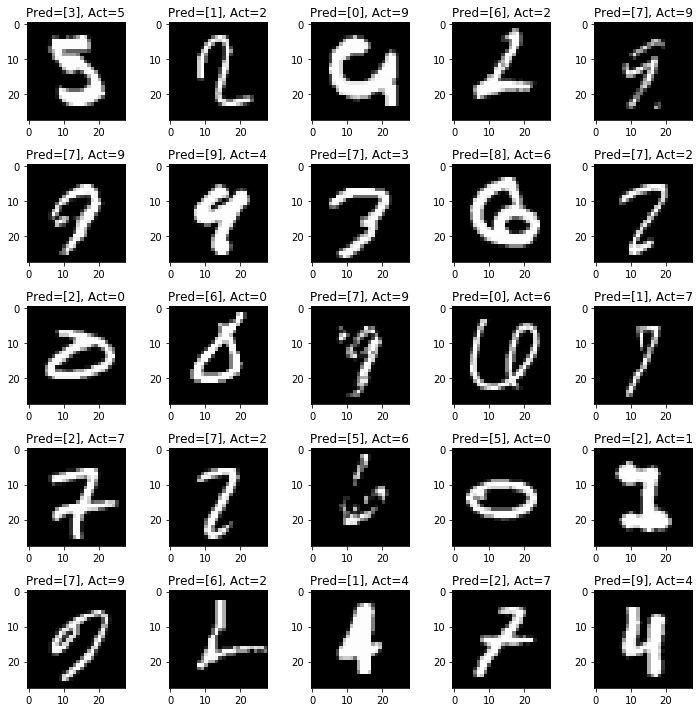

In [72]:
without_L1L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07836546748876572 Batch_id=468 Accuracy=87.73: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9842/10000 (98.42%)

EPOCH: 1


Loss=0.10968043655157089 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.07003900408744812 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.04871314391493797 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.06964780390262604 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.07562918961048126 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.052580997347831726 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.015009541064500809 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.015041468665003777 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.012978460639715195 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.030705608427524567 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.013315830379724503 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.06484433263540268 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.026484370231628418 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.01838109828531742 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.05336803197860718 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.051133230328559875 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.03913365304470062 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.011766413226723671 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.04647785425186157 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.01056384015828371 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.03678589314222336 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9924/10000 (99.24%)

EPOCH: 22


Loss=0.02987523190677166 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.027931898832321167 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9922/10000 (99.22%)

EPOCH: 24


Loss=0.07449308037757874 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.0568852461874485 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 26


Loss=0.03191233426332474 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 27


Loss=0.06011051684617996 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.029720205813646317 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Loss=0.038945093750953674 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9928/10000 (99.28%)

EPOCH: 30


Loss=0.02409788779914379 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.01185542345046997 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 32


Loss=0.05372807756066322 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)

EPOCH: 33


Loss=0.053098998963832855 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

EPOCH: 34


Loss=0.01774572767317295 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.0183300469070673 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 36


Loss=0.04315038025379181 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 37


Loss=0.023508939892053604 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 38


Loss=0.05579027906060219 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH: 39


Loss=0.016143159940838814 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)



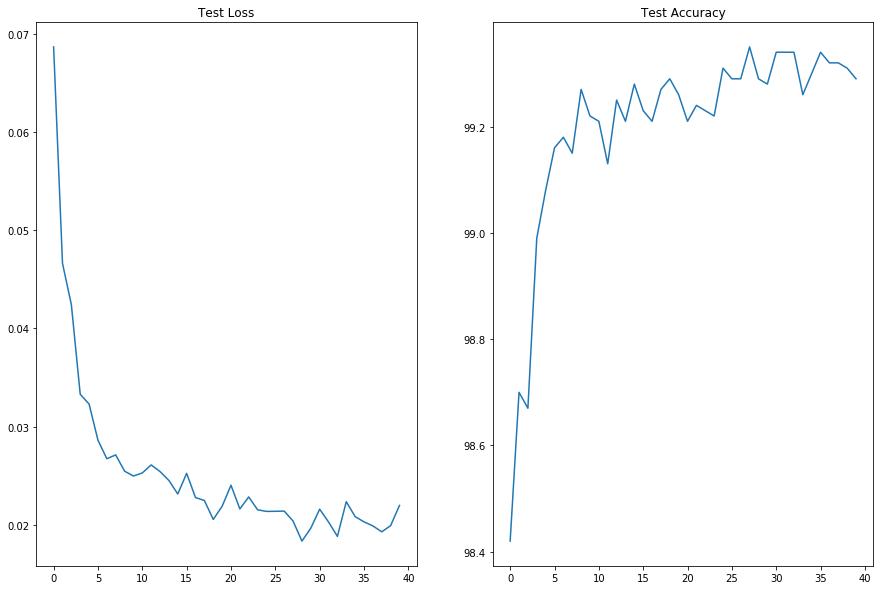

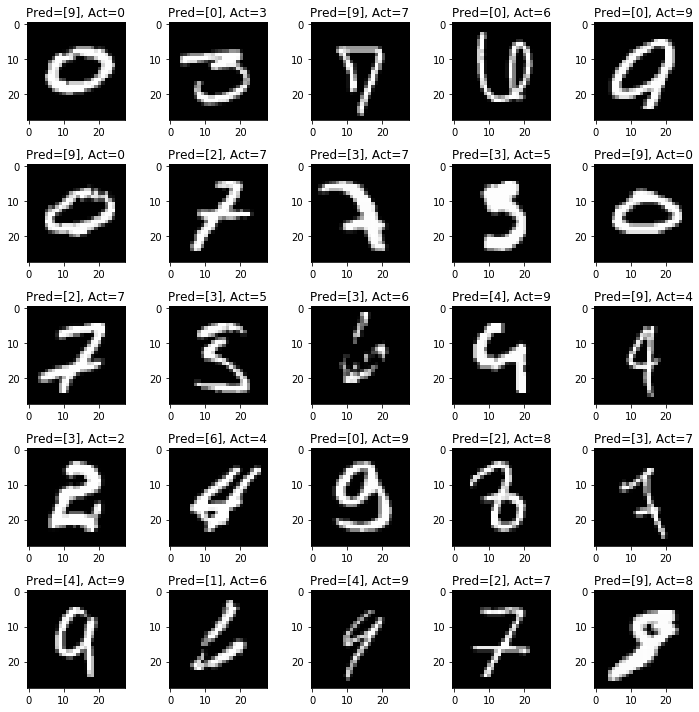

In [73]:
with_L1()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11538064479827881 Batch_id=468 Accuracy=87.14: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.1129487007856369 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.09904589504003525 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.10591532289981842 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.15091413259506226 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.0643845722079277 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.09778637439012527 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9878/10000 (98.78%)

EPOCH: 7


Loss=0.10608901083469391 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.07712166756391525 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.07780861109495163 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.08130420744419098 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.050779301673173904 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.05232599750161171 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.0944310650229454 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Loss=0.12375643104314804 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:15<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9862/10000 (98.62%)

EPOCH: 15


Loss=0.06299286335706711 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9906/10000 (99.06%)

EPOCH: 16


Loss=0.10953989624977112 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9838/10000 (98.38%)

EPOCH: 17


Loss=0.17186281085014343 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9892/10000 (98.92%)

EPOCH: 18


Loss=0.05577201768755913 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9909/10000 (99.09%)

EPOCH: 19


Loss=0.08558476716279984 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9899/10000 (98.99%)

EPOCH: 20


Loss=0.09516441822052002 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9902/10000 (99.02%)

EPOCH: 21


Loss=0.051862508058547974 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:15<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9903/10000 (99.03%)

EPOCH: 22


Loss=0.056876715272665024 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9897/10000 (98.97%)

EPOCH: 23


Loss=0.10404155403375626 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9896/10000 (98.96%)

EPOCH: 24


Loss=0.09220702201128006 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9879/10000 (98.79%)

EPOCH: 25


Loss=0.03735743463039398 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9884/10000 (98.84%)

EPOCH: 26


Loss=0.04427805915474892 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 40.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9883/10000 (98.83%)

EPOCH: 27


Loss=0.07982470095157623 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9892/10000 (98.92%)

EPOCH: 28


Loss=0.15092164278030396 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9891/10000 (98.91%)

EPOCH: 29


Loss=0.04876192659139633 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9905/10000 (99.05%)

EPOCH: 30


Loss=0.14943715929985046 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9867/10000 (98.67%)

EPOCH: 31


Loss=0.07261144369840622 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9896/10000 (98.96%)

EPOCH: 32


Loss=0.048588939011096954 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9908/10000 (99.08%)

EPOCH: 33


Loss=0.18539661169052124 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9863/10000 (98.63%)

EPOCH: 34


Loss=0.10357856750488281 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9893/10000 (98.93%)

EPOCH: 35


Loss=0.07582999765872955 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9892/10000 (98.92%)

EPOCH: 36


Loss=0.08796364814043045 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9869/10000 (98.69%)

EPOCH: 37


Loss=0.049545176327228546 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 38.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9875/10000 (98.75%)

EPOCH: 38


Loss=0.06340264528989792 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9878/10000 (98.78%)

EPOCH: 39


Loss=0.08288311958312988 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]



Test set: Average loss: 0.0532, Accuracy: 9868/10000 (98.68%)



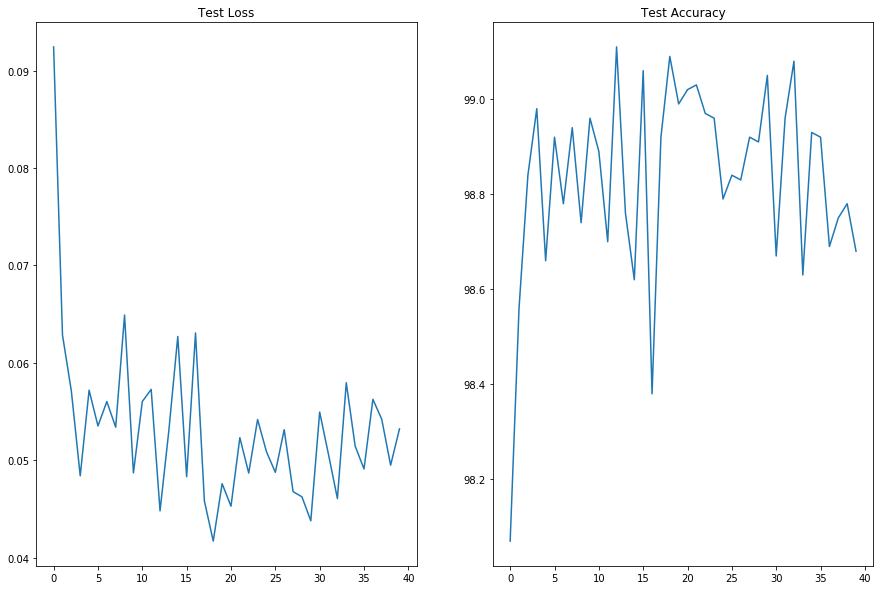

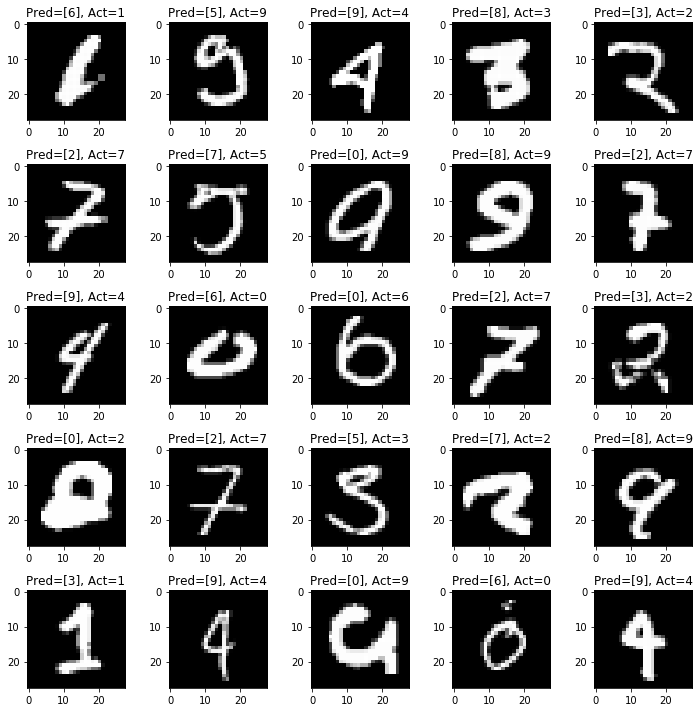

In [74]:
with_L2()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2181767374277115 Batch_id=468 Accuracy=87.44: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0926, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.08950633555650711 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.07325531542301178 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.14070060849189758 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.0985446572303772 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.08472905308008194 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.06998173147439957 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9868/10000 (98.68%)

EPOCH: 7


Loss=0.03521154820919037 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.10831954330205917 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.06206176429986954 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9899/10000 (98.99%)

EPOCH: 10


Loss=0.10070933401584625 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9894/10000 (98.94%)

EPOCH: 11


Loss=0.04522133246064186 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.06441491097211838 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.04492754861712456 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9857/10000 (98.57%)

EPOCH: 14


Loss=0.08175456523895264 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9901/10000 (99.01%)

EPOCH: 15


Loss=0.1467033177614212 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9837/10000 (98.37%)

EPOCH: 16


Loss=0.04338862746953964 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.07379106432199478 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9883/10000 (98.83%)

EPOCH: 18


Loss=0.08068951219320297 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.042061179876327515 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9874/10000 (98.74%)

EPOCH: 20


Loss=0.08417494595050812 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9893/10000 (98.93%)

EPOCH: 21


Loss=0.06500799208879471 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9884/10000 (98.84%)

EPOCH: 22


Loss=0.061437007039785385 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9869/10000 (98.69%)

EPOCH: 23


Loss=0.09293162822723389 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9895/10000 (98.95%)

EPOCH: 24


Loss=0.048016034066677094 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9904/10000 (99.04%)

EPOCH: 25


Loss=0.09915442764759064 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9909/10000 (99.09%)

EPOCH: 26


Loss=0.06071787327528 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9900/10000 (99.00%)

EPOCH: 27


Loss=0.058155614882707596 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9880/10000 (98.80%)

EPOCH: 28


Loss=0.06317347288131714 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9910/10000 (99.10%)

EPOCH: 29


Loss=0.061925388872623444 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9873/10000 (98.73%)

EPOCH: 30


Loss=0.04343678802251816 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9905/10000 (99.05%)

EPOCH: 31


Loss=0.1499544084072113 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9900/10000 (99.00%)

EPOCH: 32


Loss=0.07291361689567566 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9905/10000 (99.05%)

EPOCH: 33


Loss=0.052396081387996674 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9896/10000 (98.96%)

EPOCH: 34


Loss=0.08630159497261047 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9896/10000 (98.96%)

EPOCH: 35


Loss=0.05028960108757019 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9907/10000 (99.07%)

EPOCH: 36


Loss=0.06137733906507492 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 40.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9883/10000 (98.83%)

EPOCH: 37


Loss=0.097213514149189 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9879/10000 (98.79%)

EPOCH: 38


Loss=0.05553164705634117 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9913/10000 (99.13%)

EPOCH: 39


Loss=0.08841297775506973 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]



Test set: Average loss: 0.0549, Accuracy: 9883/10000 (98.83%)



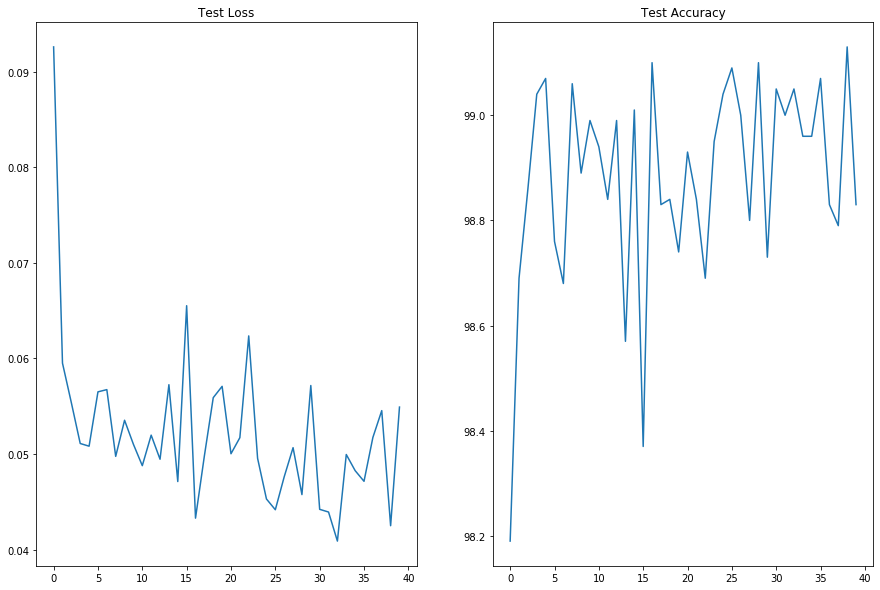

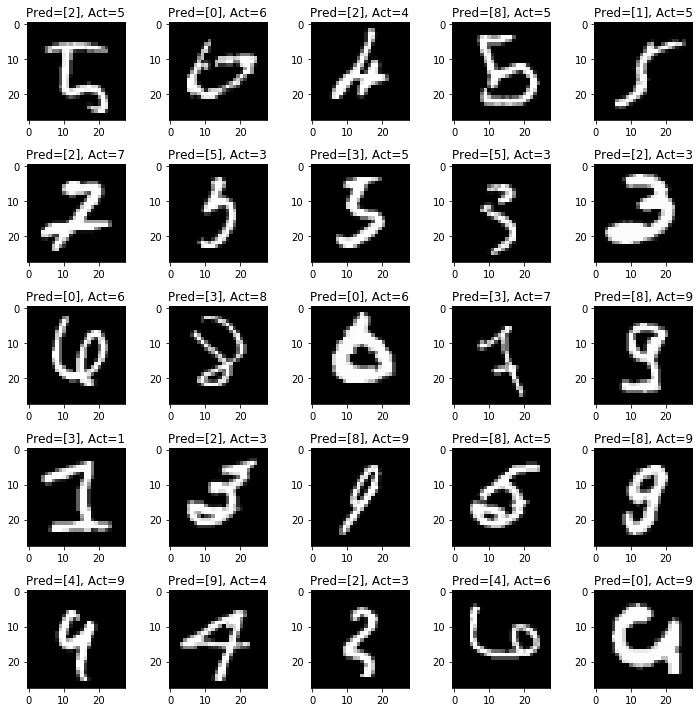

In [75]:
with_L1_L2()

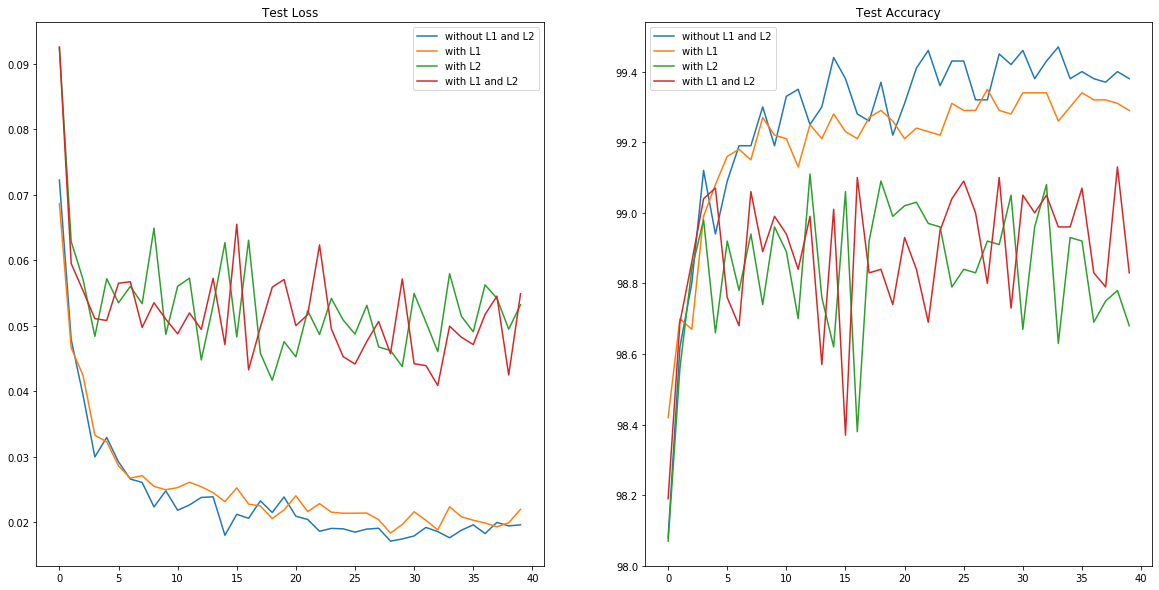

In [78]:

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_without_L1L2_Loss, label='without L1 and L2')
axs[0].plot(test_with_L1_Loss, label='with L1 ')
axs[0].plot(test_with_L2_Loss, label='with L2 ')
axs[0].plot(test_with_L1L2_Loss, label='with L1 and L2 ')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_without_L1L2_acc, label='without L1 and L2')
axs[1].plot(test_with_L1_acc, label='with L1 ')
axs[1].plot(test_with_L2_acc, label='with L2')
axs[1].plot(test_with_L1L2_acc, label='with L1 and L2 ')
axs[1].set_title("Test Accuracy")
axs[1].legend()